# Z:P biomass ratio (figures for documentation)

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs

import geoviews as gv
import holoviews as hv
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean

In [2]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result


In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [5]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [6]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [7]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [8]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)

ds= xr.open_mfdataset(newNCDFfiles,combine='by_coords')

In [9]:
## Gaby's Path 
jluo_path = '/glade/u/home/jluo/cesm_scripts/size_structured/nl_input/cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
gabyn_path = '/glade/u/home/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+new_file+'/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mmolC')
sizes

type  sname      mass_ugC       vol_um3     ESD_mm  Qp_fixed  \
1   phyto     pp  9.266989e-08  3.706795e-01   0.000891  0.004651   
2   phyto    mp1  8.241979e-06  1.805089e+01   0.003255  0.006824   
0   phyto   diaz  5.499929e-05  1.227865e+02   0.006167  0.003333   
3   phyto    mp2  8.888712e-05  8.790197e+02   0.011885  0.008656   
6   phyto  diat1  5.004513e-04  1.327390e+04   0.029376  0.010289   
9     zoo   zoo1  2.803686e-03  2.355042e+04   0.035563  0.008547   
7   phyto  diat2  3.803133e-03  1.326626e+05   0.063278  0.012602   
4   phyto    mp3  4.830334e-03  4.280541e+04   0.043401  0.012907   
8   phyto  diat3  2.890156e-02  1.325863e+06   0.136301  0.015435   
10    zoo   zoo2  8.933984e-02  7.447577e+05   0.112462  0.008547   
5   phyto    mp4  1.855836e-01  2.084484e+06   0.158489  0.018590   
11    zoo   zoo3  2.825280e+00  2.355219e+07   0.355640  0.008547   
12    zoo   zoo4  8.934658e+01  7.448139e+08   1.124647  0.008547   
13    zoo   zoo5  2.825494e+03  2.355397e+10   3.556492  0.008547   
14    zoo   zoo6  8.935332e+04  7.448701e+11  11.246757  0.008547   

           mmolC  
1   7.715418e-12  
2   6.862025e-10  
0   4.579077e-09  
3   7.400476e-09  
6   4.166608e-08  
9   2.334265e-07  
7   3.166375e-07  
4   4.021592e-07  
8   2.406258e-06  
10  7.438168e-06  
5   1.545114e-05  
11  2.352244e-04  
12  7.438730e-03  
13  2.352422e-01  
14  7.439291e+00

In [10]:
grazing=pd.read_csv(nl_config+'grazing_input_data.csv')
grazing = grazing.dropna(subset=['sname1','sname2'])
grazing = grazing[['sname1', 'sname2', 'z_umax_0_per_day']]


# calculate sum of the z_umax values
# by prey
sum_z_umax_by_prey = pd.DataFrame(grazing.groupby(['sname1'])['z_umax_0_per_day'].sum())
sum_z_umax_by_prey = sum_z_umax_by_prey.rename(index=str, columns={'z_umax_0_per_day':'sum_z_umax_by_prey'})

# by pred
sum_z_umax_by_pred = pd.DataFrame(grazing.groupby(['sname2'])['z_umax_0_per_day'].sum())
sum_z_umax_by_pred = sum_z_umax_by_pred.rename(index=str, columns={'z_umax_0_per_day':'sum_z_umax_by_pred'})

# join and calculate a per-grazer percentage
grazing = grazing.set_index('sname1').join(sum_z_umax_by_prey)
grazing['z_umax_pct_by_prey'] = grazing.z_umax_0_per_day / grazing.sum_z_umax_by_prey
grazing = grazing.reset_index()

grazing = grazing.set_index('sname2').join(sum_z_umax_by_pred)
grazing['z_umax_pct_by_pred'] = grazing.z_umax_0_per_day / grazing.sum_z_umax_by_pred
grazing = grazing.reset_index()
grazing.head(5)

sname2 sname1  z_umax_0_per_day  sum_z_umax_by_prey  z_umax_pct_by_prey  \
0   zoo1  diat1          0.147034            1.953287            0.075275   
1   zoo1   diaz          3.424788            3.603350            0.950446   
2   zoo1    mp1          3.059491            3.059491            1.000000   
3   zoo1    mp2          1.836484            7.934161            0.231465   
4   zoo1     pp          1.894655            1.894655            1.000000   

   sum_z_umax_by_pred  z_umax_pct_by_pred  
0           10.362452            0.014189  
1           10.362452            0.330500  
2           10.362452            0.295248  
3           10.362452            0.177225  
4           10.362452            0.182839

In [11]:
# clear zeros in the zooplankton carbon biomass
zoo1C = ds.zoo1C.values
zoo2C = ds.zoo2C.values
zoo3C = ds.zoo3C.values
zoo4C = ds.zoo4C.values
zoo5C = ds.zoo5C.values
zoo6C = ds.zoo6C.values

zoo1C[np.where(zoo1C < 0)] = 0
zoo2C[np.where(zoo2C < 0)] = 0
zoo3C[np.where(zoo3C < 0)] = 0
zoo4C[np.where(zoo4C < 0)] = 0
zoo5C[np.where(zoo5C < 0)] = 0
zoo6C[np.where(zoo6C < 0)] = 0

ds.zoo1C.values = zoo1C
ds.zoo2C.values = zoo2C
ds.zoo3C.values = zoo3C
ds.zoo4C.values = zoo4C
ds.zoo5C.values = zoo5C
ds.zoo6C.values = zoo6C

In [12]:
for sname in sizes.sname:
    var = sname+'C'
    newv = sname+'_n'
    sname_n = ds[var]/sizes[sizes.sname==sname].mmolC.values
    ds[newv] = sname_n
    ds[newv].attrs = {'units':'count/m^3'}

In [13]:
ZN=np.zeros(ds.zoo1_n.shape)
ZNSIZE=np.zeros(ds.zoo1_n.shape)

for zname in sizes[sizes.type=='zoo'].sname:
    zn = zname+'_n'
    ZN=ZN+ds[zn].values
    ZNSIZE = ZNSIZE + (ds[zn].values * sizes[sizes.sname==zname].ESD_mm.values)

zoo_size=ZNSIZE/ZN * 1000 
ds['zoo_size'] = (('time','z_t_150m','nlat','nlon'), zoo_size)
ds['zoo_size'].attrs = {'long_name':'Zooplankton mean size (as equivalent spherical diameter)',
                       'units':'micrometers'}

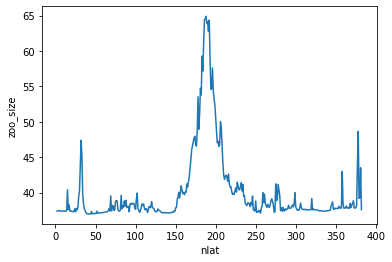

In [14]:
ds.zoo_size.mean(dim=['time','z_t_150m', 'nlon']).plot()

# Phytoplankton

In [15]:
mmolcm3pm3s_to_gpy = 1e-6 * 1.2011e-2 * 86400 * 365
mmolcm2pm2s_to_gpy = 1e-4 * 1.2011e-2 * 86400 * 365
mmolcm2pm2_to_g = 1e-4 * 1.2011e-2

In [16]:
total_prim_prod = ds.photoC_TOT.sum(dim='z_t_150m') * 10 * ds.TAREA * mmolcm2pm2s_to_gpy

print(total_prim_prod.sum(dim=['nlat', 'nlon']).mean(dim='time').values)

5.14531557337071e+16


In [17]:
POC_flux = ds.POC_FLUX_IN.isel(z_t=10) * ds.TAREA * mmolcm3pm3s_to_gpy
POC_flux.sum(dim=['nlat', 'nlon']).mean(dim='time').values

e_ratio = POC_flux / total_prim_prod
print(e_ratio)

<xarray.DataArray (time: 12, nlat: 384, nlon: 320)>
dask.array<truediv, shape=(12, 384, 320), dtype=float64, chunksize=(1, 384, 320)>
Coordinates:
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    z_t      float32 10500.0
  * time     (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00
Dimensions without coordinates: nlat, nlon


In [18]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names] # mmol C /m^3
phytoC = xr.concat([ds[v] for v in phyto_vars], dim='var').sum(dim='var') # units are mmol
phytoC_zint = phytoC.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

In [20]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names] # mmol C /m^3
phytoC_ind = xr.concat([ds[v] for v in phyto_vars], dim='var')
phytoC_ind_zint = phytoC_ind.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

In [21]:
mask_less_than_zero = phytoC_ind_zint.values < 1.065 # find all that are less than zero 
new_phytoC_ind_zint = phytoC_ind_zint.values
new_phytoC_ind_zint[mask_less_than_zero] = 0 # Make these values zero

In [22]:
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[0,:,:,:],axis=0))
x, y, zg_diaz = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[1,:,:,:],axis=0))
x, y, zg_mp1 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[2,:,:,:],axis=0))
x, y, zg_mp2 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[4,:,:,:],axis=0))
x, y, zg_mp3 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[6,:,:,:],axis=0))
x, y, zg_mp4 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[8,:,:,:],axis=0))
x, y, zg_diat1 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[3,:,:,:],axis=0))
x, y, zg_diat2 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[5,:,:,:],axis=0))
x, y, zg_diat3 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[7,:,:,:],axis=0))

### Plot phytoplankton biomass (log10, depth integrated over the top 100m)

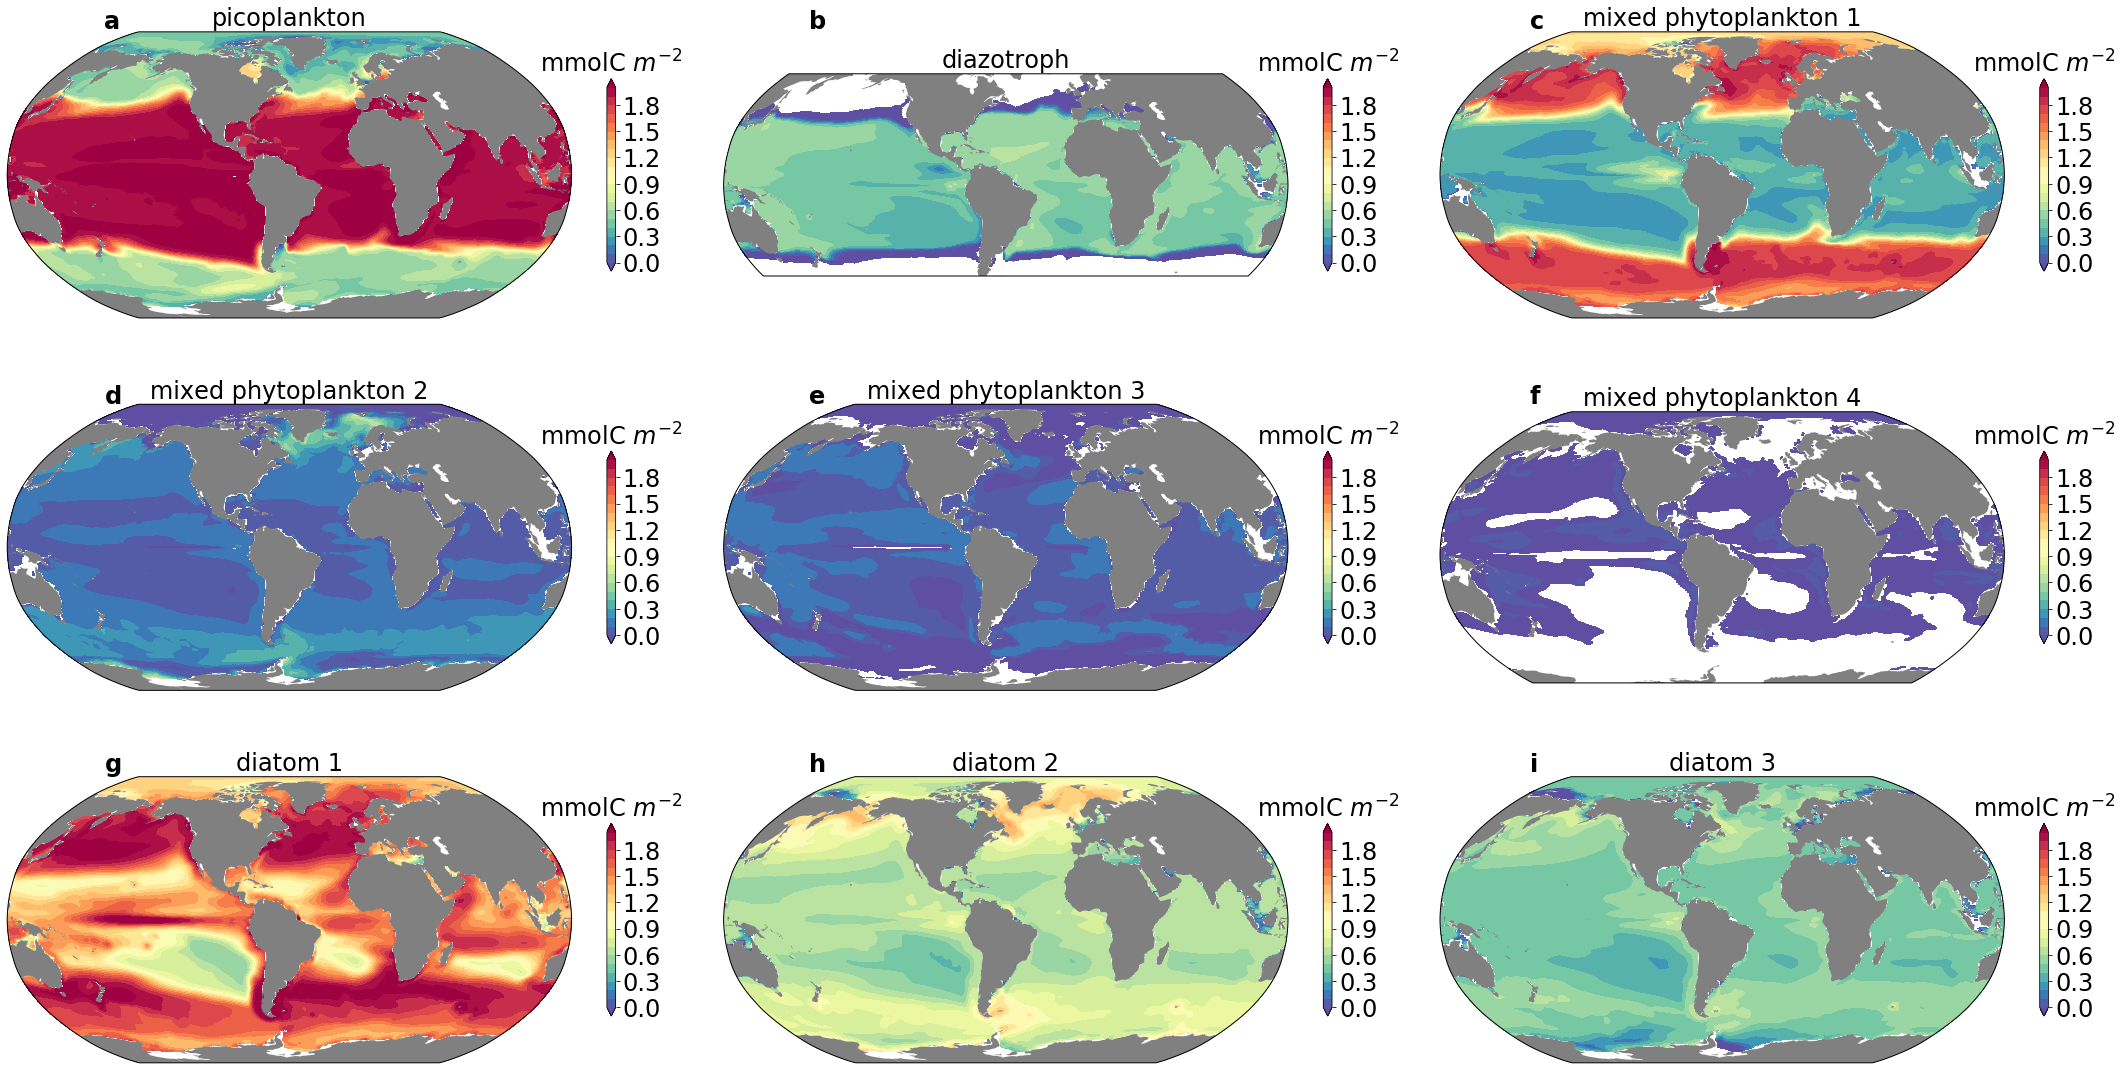

In [23]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(30, 16))
lev = np.arange(0, 2.1, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
ax = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_pp), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('picoplankton', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.05, 0.95, 'a',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_diaz), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('diazotroph', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.376, 0.95, 'b',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_mp1), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mixed phytoplankton 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.71, 0.95, 'c',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_mp2), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mixed phytoplankton 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.05, 0.625, 'd',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_mp3), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mixed phytoplankton 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.376, 0.625, 'e',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_mp4), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mixed phytoplankton 4', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.71, 0.625, 'f',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_diat1), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('diatom 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.05, 0.305, 'g',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_diat2), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('diatom 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.376, 0.305, 'h',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_diat3), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('diatom 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.71, 0.305, 'i',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)
fig.tight_layout()
plt.show()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/phyto_biomass_'+new_file+'.png',dpi=600, bbox_inches='tight')

In [24]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
zoo_vars = [''+v+'C' for v in zoo_names] # mmol C /m^3
zoo_ind = xr.concat([ds[v] for v in zoo_vars], dim='var')
zoo_ind_zint = zoo_ind.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

In [25]:
mask_less_than_zero = zoo_ind_zint.values < 1.065 # find all that are less than zero 
new_zoo_ind_zint = zoo_ind_zint.values
new_zoo_ind_zint[mask_less_than_zero] = 0 # Make these values zero

In [26]:
x, y, zg_zoo1 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[0,:,:,:],axis=0))
x, y, zg_zoo2 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[1,:,:,:],axis=0))
x, y, zg_zoo3 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[2,:,:,:],axis=0))
x, y, zg_zoo4 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[3,:,:,:],axis=0))
x, y, zg_zoo5 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[4,:,:,:],axis=0))
x, y, zg_zoo6 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[5,:,:,:],axis=0))

### Plot zooplankton biomass (log10, depth integrated over the top 100m)

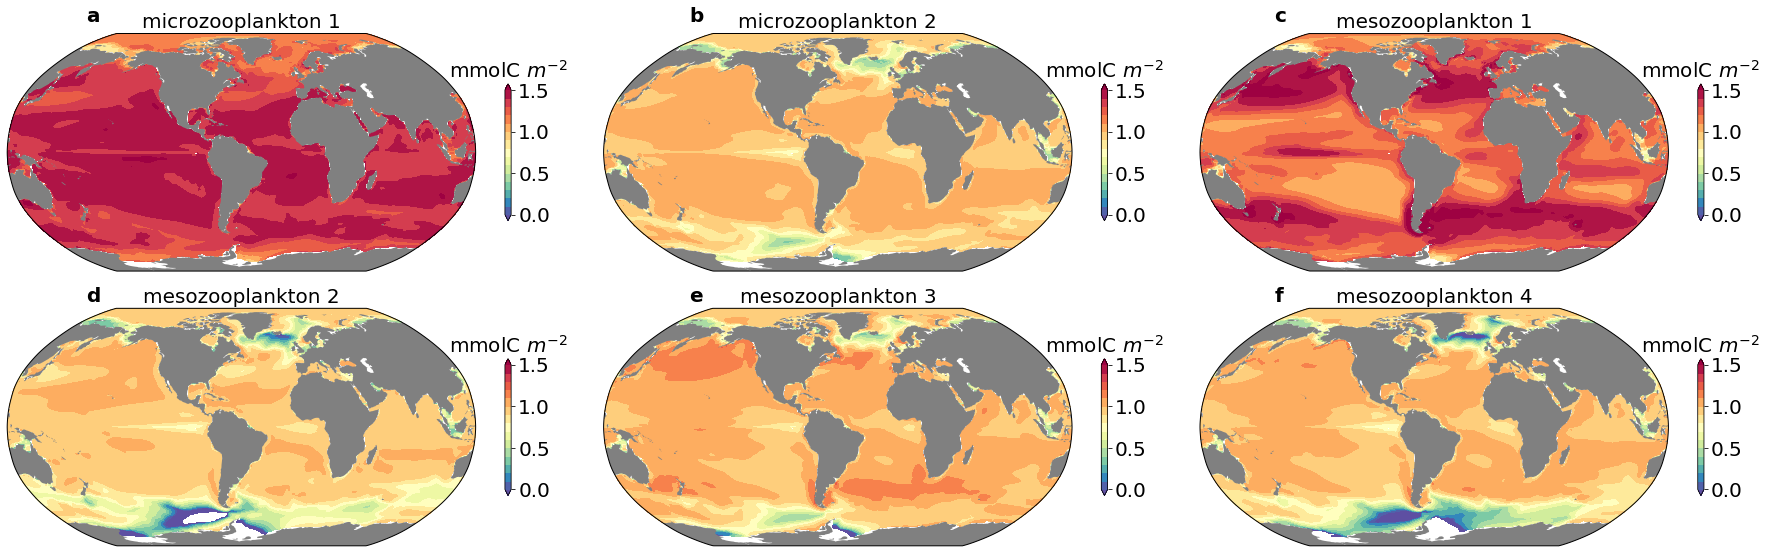

In [27]:
fig = plt.figure(figsize=(25, 8))
lev = np.arange(0, 1.51, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.75)
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_zoo1), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('microzooplankton 1', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.05, 0.96, 'a',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_zoo2), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('microzooplankton 2', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.385, 0.96, 'b',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_zoo3), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mesozooplankton 1', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.71, 0.96, 'c',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_zoo4), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mesozooplankton 2', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.05, 0.475, 'd',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_zoo5), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mesozooplankton 3', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.385, 0.475, 'e',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_zoo6), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mesozooplankton 4', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.71, 0.475, 'f',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

fig.tight_layout()
plt.show()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/zoo_biomass_'+new_file+'.png',dpi=600, bbox_inches='tight')

# Zooplankton

In [28]:
microzoo = ['zoo1', 'zoo2']
mesozoo = ['zoo3', 'zoo4', 'zoo5', 'zoo6']

ds['microzooProd_zint'] = xr.concat([ds['x_graze_' + v + '_zint'] for v in microzoo], dim='var').sum(dim='var')
ds['mesozooProd_zint'] = xr.concat([ds['x_graze_' + v + '_zint'] for v in mesozoo], dim='var').sum(dim='var')

microzooProd = ds['microzooProd_zint'] * ds.TAREA * mmolcm3pm3s_to_gpy
print('Microzooplankton Production: ' + '{:.2e}'.format(microzooProd.mean(dim='time').sum().values) + ' Pg C yr-1')

mesozooProd = ds['mesozooProd_zint'] * ds.TAREA * mmolcm3pm3s_to_gpy
print('Mesozooplankton Production: ' + '{:.2e}'.format(mesozooProd.mean(dim='time').sum().values) + ' Pg C yr-1')

Microzooplankton Production: 8.77e+15 Pg C yr-1
Mesozooplankton Production: 3.32e+15 Pg C yr-1


In [32]:
microzoo = ['zoo1', 'zoo2']
mesozoo = ['zoo3', 'zoo4', 'zoo5', 'zoo6']

ds['microzooC_zint'] = xr.concat([ds[v+'C'] for v in microzoo], dim='var').sum(dim='var')
ds['microzooC_zint'] = ds['microzooC_zint'].sum(dim='z_t_150m') * 10
ds['mesozooC_zint'] = xr.concat([ds[v+'C'] for v in mesozoo], dim='var').sum(dim='var')
ds['mesozooC_zint'] = ds['mesozooC_zint'].sum(dim='z_t_150m') * 10

microzooC = ds['microzooC_zint'] * ds.TAREA * mmolcm2pm2_to_g
print('Microzooplankton Carbon: ' + '{:.2e}'.format(microzooC.sum().values) + ' Pg C')

mesozooC = ds['mesozooC_zint'] * ds.TAREA * mmolcm2pm2_to_g
print('Mesozooplankton Carbon: ' + '{:.2e}'.format(mesozooC.sum().values) + ' Pg C')

Microzooplankton Carbon: 1.74e+15 Pg C
Mesozooplankton Carbon: 2.38e+15 Pg C


In [33]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
zoo_vars = ['x_graze_'+v+'_zint' for v in zoo_names]
zooProd_TOT = xr.concat([ds[v] for v in zoo_vars], dim='var').sum(dim='var') # units are mmol m-3 * cm s-1
zooProd_TOT = ((zooProd_TOT / 100) * ds.TAREA / 1e4).sum(dim=['nlat','nlon'])
zooProd_TOT = zooProd_TOT.mean(dim='time') * (60*60*24*365) # mmol y-1
zooProd_TOT = zooProd_TOT * 12.011 /1e3 # g C y-1
print(np.format_float_scientific(zooProd_TOT.values,2))

1.21e+16


In [34]:
zoo_var_names = ['zoo1', 'zoo2','zoo3', 'zoo4', 'zoo5', 'zoo6']
total_zoo_prod = xr.concat([ds['x_graze_' + v + '_zint'] for v in zoo_var_names], dim='var').sum(dim='var') * ds.TAREA * mmolcm3pm3s_to_gpy # mmol/m^3 cm/s to g C yr-1

zooC = xr.concat([ds[v+'C'] for v in zoo_var_names], dim='var').sum(dim='var')
zooC_zint = zooC.sum(dim='z_t_150m') * 10

In [37]:
mask_less_than_zero = zooC_zint.values < 1.065 # find all that are less than zero 
new_zooC_zint = zooC_zint.values
new_zooC_zint[mask_less_than_zero] = 0 # Make these values zero

In [39]:
new_zooC_zint.shape

(12, 384, 320)

In [51]:
new_phytoC_zint = np.sum(new_phytoC_ind_zint,axis=0)

In [52]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Plot phytoplankton biomass, zooplankton biomass and Z:P biomass ratio, to be able to compare them better within them

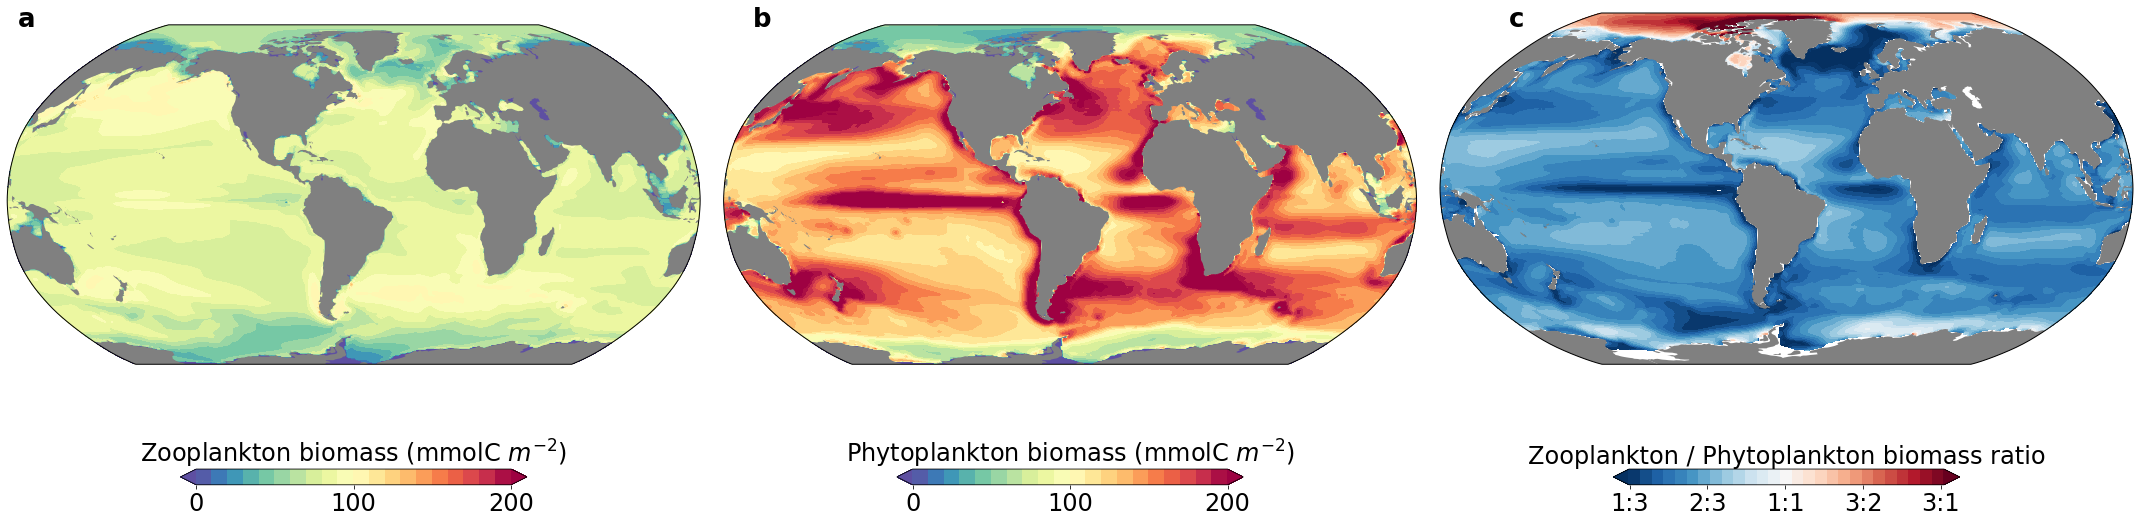

In [53]:
fig = plt.figure(figsize=(30, 10))

lev = np.arange(0, 201, 10)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=100)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zooC_zint,axis=0))
ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,100,200],shrink=0.5, orientation='horizontal')
cb.ax.set_title('Zooplankton biomass (mmolC $m^{-2}$)', fontsize = 24)
cb.ax.tick_params(labelsize=24)


lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_zint,axis=0))
ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,100,200],shrink=0.5, orientation='horizontal')
cb.ax.set_title('Phytoplankton biomass (mmolC $m^{-2}$)', fontsize = 24)
cb.ax.tick_params(labelsize=24)


lev = np.arange(0.33, 1.7, 0.05)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
levels = [1]
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zooC_zint,axis=0)/np.mean(new_phytoC_zint,axis=0))
ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='RdBu_r',vmin = 0.33, vmax=1.7,levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0.333,0.666,1,1.333,1.666],shrink=0.5, orientation='horizontal')
cb.ax.set_xticklabels(['1:3','2:3','1:1','3:2','3:1'])
cb.ax.set_title('Zooplankton / Phytoplankton biomass ratio', fontsize = 24)
cb.ax.tick_params(labelsize=24)
fig.text(0.01, 0.775, 'a',fontsize=26, fontweight='bold')
fig.text(0.35, 0.775, 'b',fontsize=26, fontweight='bold')
fig.text(0.7, 0.775, 'c',fontsize=26, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/biomass_ZPratio_'+new_file+'.png',dpi=600, bbox_inches='tight')

In [34]:
month = np.arange(1,13,1)
zooC_clim = np.sum(zooC_zint, axis = (1,2))
phytoC_clim = np.sum(phytoC_zint, axis = (1,2))

### Compare zooplankton and phytoplankton global biomass seasonally

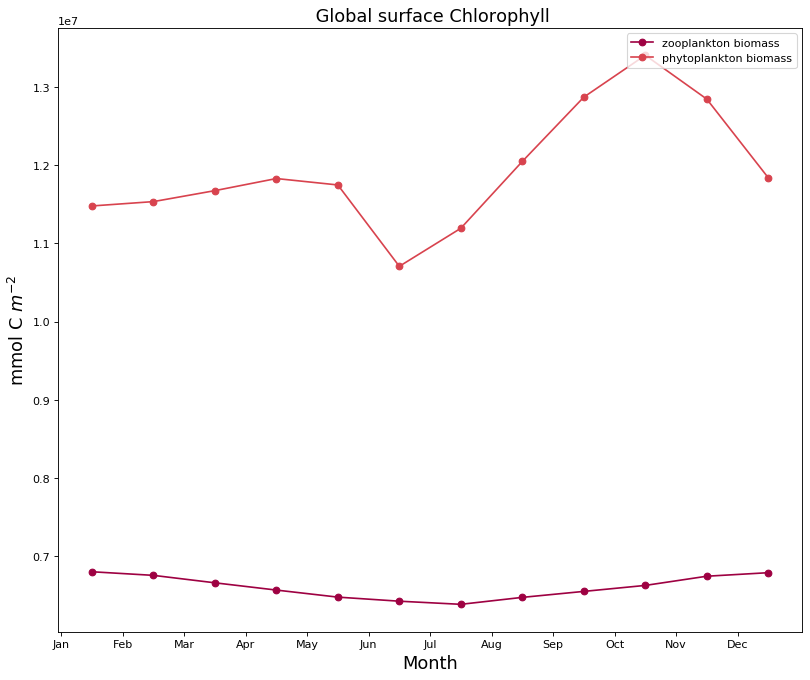

In [35]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)
#dep = ds.z_t/100
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,zooC_clim, '-o', color=cmap(0),label='zooplankton biomass')
pylab.plot(month,phytoC_clim, '-o', color=cmap(1),label='phytoplankton biomass')
plt.xticks(np.arange(0.5,12.5,1), ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

pylab.legend(loc='upper right')
pylab.ylabel('mmol C $m^{-2}$', fontsize=16)
pylab.xlabel('Month', fontsize=16)
pylab.title(' Global surface Chlorophyll', fontsize=16)
pylab.show()

### phytoplankton biomass compared to zooplankton biomass

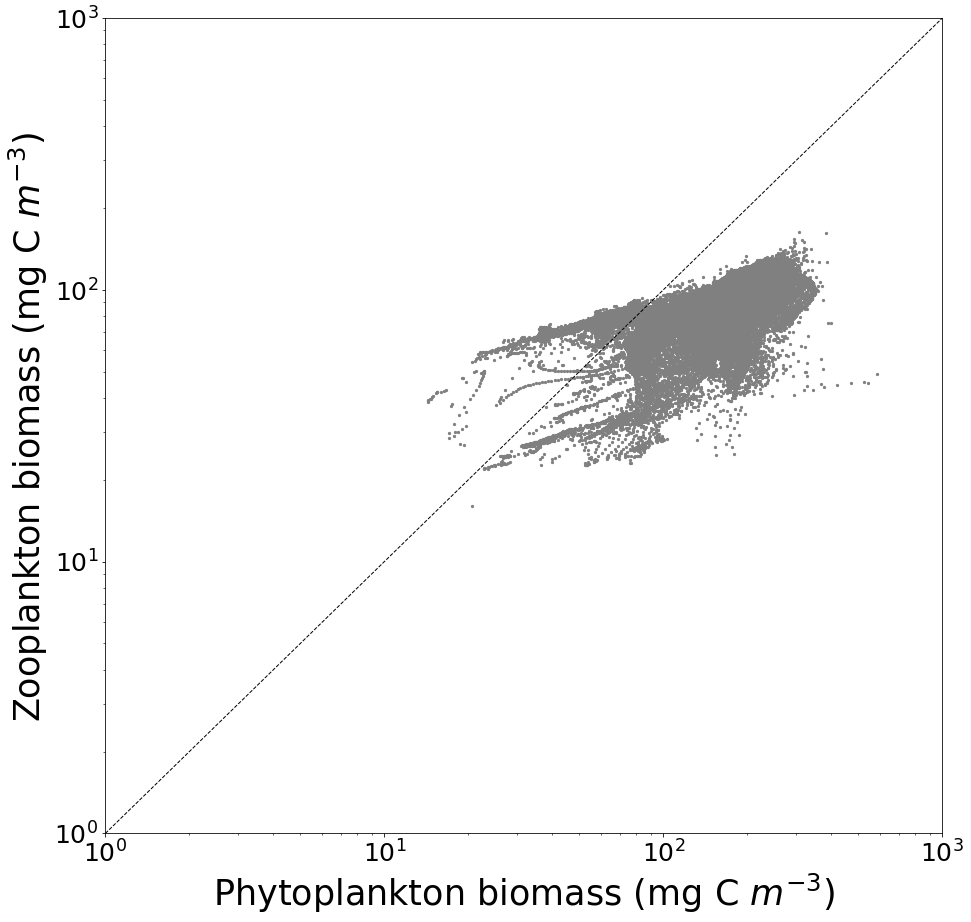

In [38]:
from scipy import stats
#fig, ax = plt.figure(figsize=(10, 10))
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
X=phytoC.sum(dim='z_t_150m').mean(dim='time')*12.011
Y=zooC.sum(dim='z_t_150m').mean(dim='time')*12.011

plt.scatter(y=Y,x=X, s=5, alpha=1,color='gray')
#slope, intercept, r_value, p_value, std_err = stats.linregress(x=X,y=Y)
plt.plot([1, 1000], [1, 1000], color='k', linestyle='--', linewidth=1)
#plt.text(x=1,y=-0.5,s=('y = '+'{:.2f}'.format(slope)+'x + '+'{:.2f}'.format(intercept)), horizontalalignment='left', fontsize = 20)
#x_vals = np.linspace(-1,1,1000)
#plt.plot(x_vals, x_vals*slope + intercept, color='k', linestyle='-', linewidth=2.5)
#fig, ax = plt.subplots()
ax.axis([1, 1000, 1, 1000])
ax.loglog()
#for axis in [ax.xaxis, ax.yaxis]:
#    formatter = ScalarFormatter()
#    formatter.set_scientific(False)
#   axis.set_major_formatter(formatter)
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('Phytoplankton biomass (mg C $m^{-3}$)', fontsize=35)
plt.ylabel('Zooplankton biomass (mg C $m^{-3}$) ',fontsize = 35)
#fig.text(0, 0.9, 'c',fontsize=35, fontweight='bold')
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Z_P_scatter'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

## Is there some relationship?

In [39]:
xx = X.values.flatten()
yy = Y.values.flatten()

In [40]:
mymodel = np.poly1d(np.polyfit(xx, yy, 2))
myline = np.linspace(50, 400, 400)

Text(0, 0.5, 'Zooplankton biomass (mg C $m^{-3}$) ')

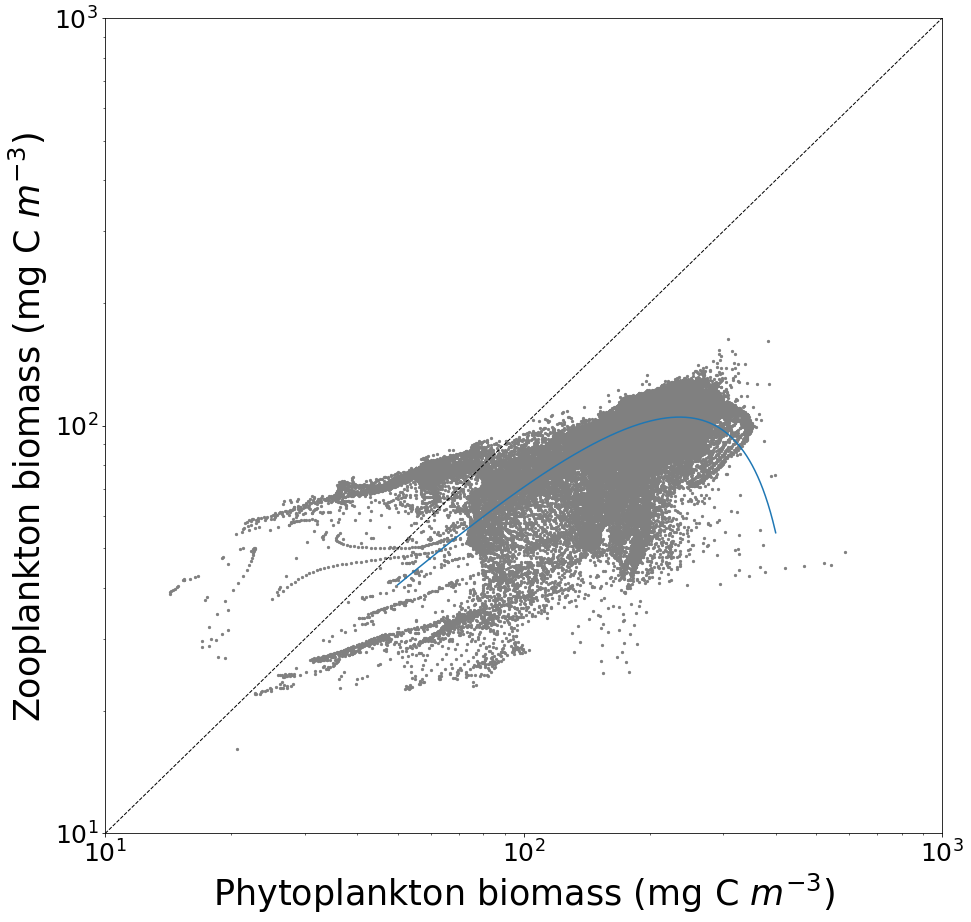

In [41]:
from scipy import stats
#fig, ax = plt.figure(figsize=(10, 10))
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.scatter(y=yy,x=xx, s=5, alpha=1,color='gray')
plt.plot(myline, mymodel(myline))
#slope, intercept, r_value, p_value, std_err = stats.linregress(x=X,y=Y)
plt.plot([10, 1000], [10, 1000], color='k', linestyle='--', linewidth=1)
#plt.text(x=1,y=-0.5,s=('y = '+'{:.2f}'.format(slope)+'x + '+'{:.2f}'.format(intercept)), horizontalalignment='left', fontsize = 20)
#x_vals = np.linspace(-1,1,1000)
#plt.plot(x_vals, x_vals*slope + intercept, color='k', linestyle='-', linewidth=2.5)
#fig, ax = plt.subplots()
ax.axis([10, 1000, 10, 1000])
ax.loglog()
#for axis in [ax.xaxis, ax.yaxis]:
#    formatter = ScalarFormatter()
#    formatter.set_scientific(False)
#   axis.set_major_formatter(formatter)
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('Phytoplankton biomass (mg C $m^{-3}$)', fontsize=35)
plt.ylabel('Zooplankton biomass (mg C $m^{-3}$) ',fontsize = 35)

## Log10 (zooplankton biomass vs phytoplankton biomass)

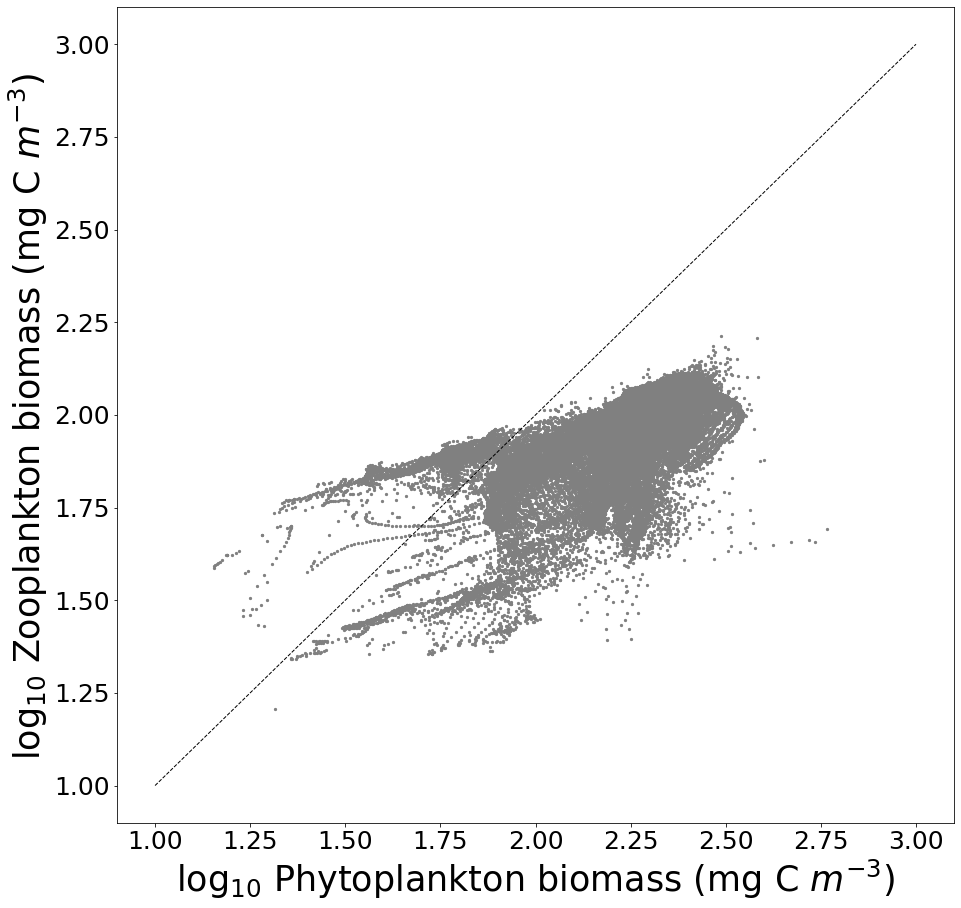

In [42]:
from scipy import stats
#fig, ax = plt.figure(figsize=(10, 10))
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.scatter(y=np.log10(yy),x=np.log10(xx), s=5, alpha=1,color='gray')
#plt.plot(myline, mymodel(myline))
#slope, intercept, r_value, p_value, std_err = stats.linregress(x=X,y=Y)
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
#plt.text(x=1,y=-0.5,s=('y = '+'{:.2f}'.format(slope)+'x + '+'{:.2f}'.format(intercept)), horizontalalignment='left', fontsize = 20)
#x_vals = np.linspace(-1,1,1000)
#plt.plot(x_vals, x_vals*slope + intercept, color='k', linestyle='-', linewidth=2.5)
#fig, ax = plt.subplots()
#ax.axis([10, 1000, 10, 1000])
#ax.loglog()
#for axis in [ax.xaxis, ax.yaxis]:
#    formatter = ScalarFormatter()
#    formatter.set_scientific(False)
#   axis.set_major_formatter(formatter)
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('log$_{10}$ Phytoplankton biomass (mg C $m^{-3}$)', fontsize=35)
plt.ylabel('log$_{10}$ Zooplankton biomass (mg C $m^{-3}$) ',fontsize = 35)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Z_P_scatter_log'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

# Abundance using depth-averaged biomass 
$$Abundance = \frac{Biomass}{Mass}$$
Where: 
* $biomass$ is in units of [$\frac{\mu gC}{m^3}$] 
* $mass$ is in [$\mu g C$]
    * converting the $Abundance$ into units of [$\frac{cell}{ m^3}$]
​
We want unts of: 
* $\frac{cell}{L}$ for both zooplankton and phytoplankton

We want unts of: 
* $\frac{cell}{mL}$ for both zooplankton and phytoplankton

In [43]:
## Volume 
# units [um^3]
pp_v = 0.195428825646897
mp1_v = 37.6111075368976
diaz_v = 122.786536059293
diat1_v = 4187.92236603257
mp2_v = 7238.41739042113
diat2_v = 374617.983936749
mp3_v = 1393064.17037973
diat3_v = 33510323.645704
mp4_v = 268101116.324664

# units [mm^3] into [um^3]
zoo1_v = 5.23598775598299E-07 * 1e9
zoo2_v = 5.00745000930114E-05 * 1e9
zoo3_v = 0.00478888736265629 * 1e9
zoo4_v = 0.457986442792462 * 1e9
zoo5_v = 43.7996482058306 * 1e9
zoo6_v = 4188.79033024969 * 1e9

## Mass
# units [ug C]
pp_m = 4.88572064117242E-08
mp1_m = 1.70475047067261E-05
diaz_m = 5.49992918958176E-05
diat1_m = 0.000181125995838518
mp2_m = 0.000910343637769569
diat2_m = 0.00949142840730853
mp3_m = 0.127112682492814
diat3_m = 0.497373183755356
mp4_m = 17.7489393896427

# units [mg C] to [ug C]
zoo1_m = 7.86253129691093E-08 * 1000
zoo2_m = 5.69328191250882E-06 * 1000
zoo3_m = 0.000574466613113713 * 1000
zoo4_m = 0.0549392584788313 * 1000
zoo5_m = 5.25412974975864 * 1000
zoo6_m = 502.48001505036 * 1000

phyto_mass = array([pp_m,mp1_m, diaz_m, diat1_m,mp2_m,diat2_m,mp3_m,diat3_m,mp4_m])
phyto_vol = array([pp_v,mp1_v, diaz_v, diat1_v,mp2_v,diat2_v,mp3_v,diat3_v,mp4_v])
zoo_mass = array([zoo1_m, zoo2_m, zoo3_m, zoo4_m, zoo5_m, zoo6_m])
zoo_vol = array([zoo1_v, zoo2_v, zoo3_v, zoo4_v, zoo5_v, zoo6_v])

In [44]:
zoo1C = ds.zoo1C.sum(dim='z_t_150m') * 10/150*12010 # multiply by 10m depths, divide by 150m total, and convert from mmol C to ug carbon. 
zoo2C = ds.zoo2C.sum(dim='z_t_150m') * 10/150*12010
zoo3C = ds.zoo3C.sum(dim='z_t_150m') * 10/150*12010
zoo4C = ds.zoo4C.sum(dim='z_t_150m') * 10/150*12010
zoo5C = ds.zoo5C.sum(dim='z_t_150m') * 10/150*12010
zoo6C = ds.zoo6C.sum(dim='z_t_150m') * 10/150*12010
zoo1_abundance = zoo1C/zoo1_m # ugC /m^3 /ugC
zoo2_abundance = zoo2C/zoo2_m
zoo3_abundance = zoo3C/zoo3_m
zoo4_abundance = zoo4C/zoo4_m
zoo5_abundance = zoo5C/zoo5_m
zoo6_abundance = zoo6C/zoo6_m
total_zoo_abundance = np.stack([zoo1_abundance,zoo2_abundance,zoo3_abundance,zoo4_abundance,zoo5_abundance,zoo6_abundance])
tza =np.nanmean(total_zoo_abundance, axis = (0,1))

In [45]:
diat1C = ds.diat1C.sum(dim='z_t_150m') * 10/150*12010 # multiply by 10m depths, divide by 150m total, and convert from mmol C to ug carbon. 
diat2C = ds.diat2C.sum(dim='z_t_150m') * 10/150*12010
diat3C = ds.diat3C.sum(dim='z_t_150m') * 10/150*12010
mp1C = ds.mp1C.sum(dim='z_t_150m') * 10/150*12010
mp2C = ds.mp2C.sum(dim='z_t_150m') * 10/150*12010
mp3C = ds.mp3C.sum(dim='z_t_150m') * 10/150*12010
mp4C = ds.mp4C.sum(dim='z_t_150m') * 10/150*12010
diazC = ds.diazC.sum(dim='z_t_150m') * 10/150*12010
ppC = ds.ppC.sum(dim='z_t_150m') * 10/150*12010
diat1_abundance = diat1C/diat1_m # ugC /m^3 /ugC
diat2_abundance = diat2C/diat2_m
diat3_abundance = diat3C/diat3_m
mp1_abundance = mp1C/mp1_m
mp2_abundance = mp2C/mp2_m
mp3_abundance = mp3C/mp3_m
mp4_abundance = mp4C/mp4_m
pp_abundance = ppC/pp_m
diaz_abundance = diazC/diaz_m
total_phyto_abundance = np.stack([diat1_abundance,diat2_abundance,diat3_abundance,mp1_abundance,mp2_abundance,mp3_abundance,mp4_abundance,pp_abundance,diaz_abundance])
tpa =np.nanmean(total_phyto_abundance, axis = (0,1))

In [46]:
xxx = tpa.flatten()
yyy = tza.flatten()
mymodel = np.poly1d(np.polyfit(xx, yy, 2))
myline = np.linspace(0, 10, 10)

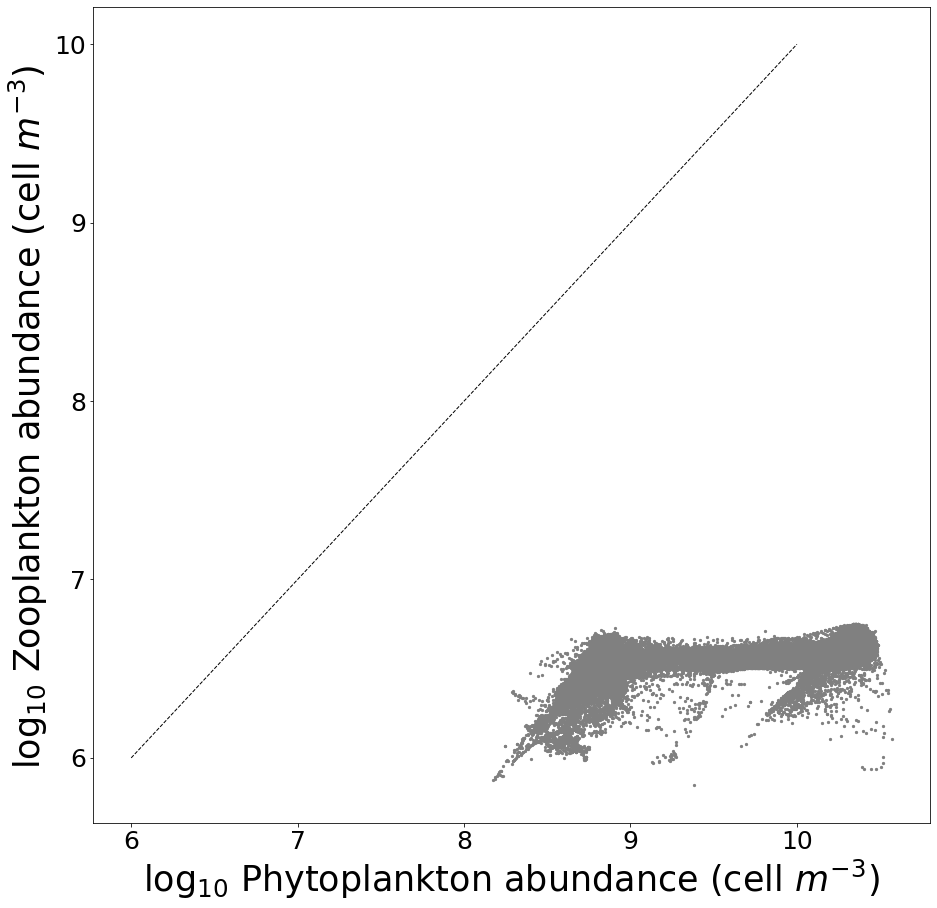

In [47]:
from scipy import stats
#fig, ax = plt.figure(figsize=(10, 10))
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.scatter(y=np.log10(yyy),x=np.log10(xxx), s=5, alpha=1,color='gray')
#plt.plot(myline, mymodel(myline))
#slope, intercept, r_value, p_value, std_err = stats.linregress(x=X,y=Y)
plt.plot([6, 10], [6, 10], color='k', linestyle='--', linewidth=1)
#plt.text(x=1,y=-0.5,s=('y = '+'{:.2f}'.format(slope)+'x + '+'{:.2f}'.format(intercept)), horizontalalignment='left', fontsize = 20)
#x_vals = np.linspace(-1,1,1000)
#plt.plot(x_vals, x_vals*slope + intercept, color='k', linestyle='-', linewidth=2.5)
#fig, ax = plt.subplots()
#ax.axis([6, 10, 6, 10])
#ax.loglog()
#for axis in [ax.xaxis, ax.yaxis]:
#    formatter = ScalarFormatter()
#    formatter.set_scientific(False)
#   axis.set_major_formatter(formatter)
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('log$_{10}$ Phytoplankton abundance (cell $m^{-3}$)', fontsize=35)
plt.ylabel('log$_{10}$ Zooplankton abundance (cell $m^{-3}$) ',fontsize = 35)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Z_P_scatter_log_abundance'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

In [48]:
mymodel

poly1d([-0.0018643 ,  0.87871806,  1.43412579])

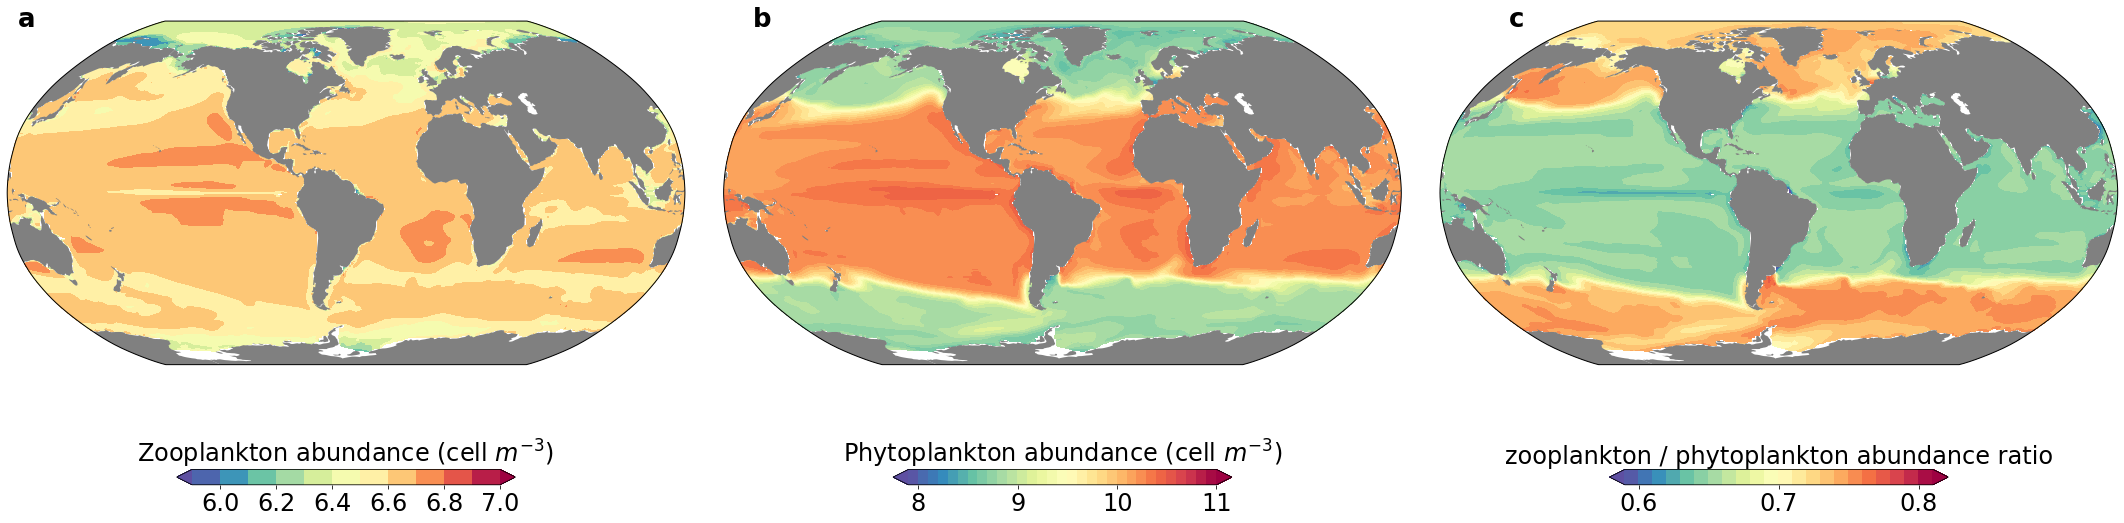

In [76]:
fig = plt.figure(figsize=(30, 10))

lev = np.arange(5.9, 7.01, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=6.5)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.log10(tza))
ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[6,6.2,6.4,6.6,6.8,7],shrink=0.5, orientation='horizontal')
cb.ax.set_title('Zooplankton abundance (cell $m^{-3}$)', fontsize = 24)
cb.ax.tick_params(labelsize=24)

lev = np.arange(7.9, 11.1, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=9.5)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.log10(tpa))
ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[8,9,10,11],shrink=0.5, orientation='horizontal')
cb.ax.set_title('Phytoplankton abundance (cell $m^{-3}$)', fontsize = 24)
cb.ax.tick_params(labelsize=24)
#fig.text(0.15, 0.89, 'a',fontsize=14, fontweight='bold')

lev = np.arange(0.59, 0.81, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.7)
#levels = [1]
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT,np.log10(tza)/np.log10(tpa))
ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0.6,0.7,0.8],shrink=0.5, orientation='horizontal')
cb.ax.set_title('zooplankton / phytoplankton abundance ratio', fontsize = 24)
cb.ax.tick_params(labelsize=24)
fig.text(0.01, 0.775, 'a',fontsize=26, fontweight='bold')
fig.text(0.35, 0.775, 'b',fontsize=26, fontweight='bold')
fig.text(0.7, 0.775, 'c',fontsize=26, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/abundance_ZPratio_'+new_file+'.png',dpi=600, bbox_inches='tight')

### this shows that there are more phytoplankton than zooplankton throughout the globe, so all of the ratios are actually below one. But still, polar regions and subpolar regions tend to have higher Z:P ratios than upwelling regions. This is consitent with some studies in lakes and gasol et al. 1997. 

## Now compare with Biomes

In [50]:
biome_mask = xr.open_dataset('/glade/u/home/jluo/p/tools/biomes/g.e20.G1850ECOIAF.t62_g17.marbl0_22_0.test117/biomes_mask_0033_0062.nc')
biome_mask = biome_mask.isel(time=0)
biome_mask.reset_coords('time', drop=True)

region_names = ['Eq-D','Eq-U','S-ST-PS','N-ST-PS','S-ST-SS','N-ST-SS','S-LL-U','N-LL-U','S-SP-SS','N-SP-SS','S-SIZ','N-SIZ']
region_NtoS_index = [11,9,5,3,7,1,0,6,2,4,8,10]
region_NtoS_names = [region_names[i] for i in region_NtoS_index]

biome_mask_x1 = xr.open_dataset('/glade/u/home/jluo/p/tools/biomes/biomes_mask_regularx1.nc')
biome_mask_x04 = xr.open_dataset('/glade/u/home/jluo/p/tools/biomes/biomes_mask_regularx04.nc')

In [ ]:
nt = len(ds.time.values)

rmask = np.zeros(shape=(nt,)+biome_mask.REGION_MASK.shape)
rmask3 = np.zeros(shape=(nt,)+biome_mask.REGION_MASK_3D.shape)

rmask_val = biome_mask.REGION_MASK.values
rmask3_val = biome_mask.REGION_MASK_3D.values

for i in range(nt):
    rmask[i,:,:]=rmask_val
    rmask3[i,:,:,:]=rmask3_val
    
biome_mask['rmask'] = xr.DataArray(rmask, coords={'time':range(nt), 'nlat':biome_mask.nlat.values, 'nlon':biome_mask.nlon.values}, dims=['time', 'nlat', 'nlon'])
biome_mask['rmask'].attrs=biome_mask['REGION_MASK'].attrs
biome_mask['rmask3'] = xr.DataArray(rmask3, coords={'time':range(nt), 'region':biome_mask.region.values, 'nlat':biome_mask.nlat.values, 'nlon':biome_mask.nlon.values}, dims=['time', 'region', 'nlat', 'nlon'])
biome_mask['rmask3'].attrs=biome_mask['REGION_MASK_3D'].attrs

biome_mask['REGION_MASK'] = biome_mask['rmask']
biome_mask['REGION_MASK_3D'] = biome_mask['rmask3']
biome_mask = biome_mask.drop(['rmask', 'rmask3'])

In [52]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

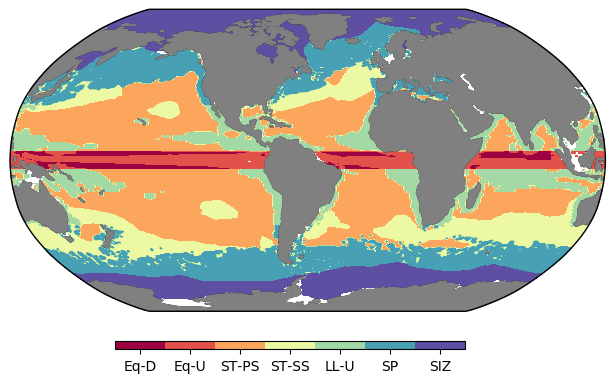

In [53]:
lon = biome_mask.TLONG.values
lat = biome_mask.TLAT.values
field = biome_mask.REGION_MASK[0,:,:].values
lon,lat,field = adjust_pop_grid(lon,lat,field)

fig = plt.figure(figsize=(10, 4),dpi=100)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines()
ax.set_global()

land = ax.add_feature(
   cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                       edgecolor='face',
                                       facecolor='gray'))
cf = plt.contourf(lon,lat, field, levels=range(8), cmap=discrete_cmap(8,'Spectral'), transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.32, 0.03, 0.35, 0.02])
cbar = fig.colorbar(cf, cax=cbar_ax, shrink=0.5, spacing='uniform',ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],orientation="horizontal")
cbar.ax.set_xticklabels(['Eq-D','Eq-U','ST-PS','ST-SS','LL-U','SP','SIZ'],fontsize = 10)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/biomes.png',dpi=600, bbox_inches='tight')

In [54]:
nbiome = len(biome_mask.region.values)
nt = len(ds.time.values)

In [55]:
biome_means = np.zeros(shape=(nt,nbiome,2))

In [56]:
X=phytoC.sum(dim='z_t_150m').mean(dim='time') *12.011
Y=zooC.sum(dim='z_t_150m').mean(dim='time')*12.011

In [57]:
# 'N_SIZ'
region_N_SIZ = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[0]).values == 1)
phyto_N_SIZ = np.log10(X).values[region_N_SIZ] 
zoo_N_SIZ = np.log10(Y).values[region_N_SIZ] 

# N_SP_SS
region_N_SP_SS = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[1]).values == 1)
phyto_N_SP_SS = np.log10(X).values[region_N_SP_SS] 
zoo_N_SP_SS = np.log10(Y).values[region_N_SP_SS] 

# N_ST_SS
region_N_ST_SS = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[2]).values == 1)
phyto_N_ST_SS = np.log10(X).values[region_N_ST_SS]
zoo_N_ST_SS = np.log10(Y).values[region_N_ST_SS] 

# N_ST_PS
region_N_ST_PS = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[3]).values == 1)
phyto_N_ST_PS = np.log10(X).values[region_N_ST_PS] 
zoo_N_ST_PS = np.log10(Y).values[region_N_ST_PS] 

# N_LL_U
region_N_LL_U = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[4]).values == 1)
phyto_N_LL_U = np.log10(X).values[region_N_LL_U] 
zoo_N_LL_U = np.log10(Y).values[region_N_LL_U]

# Eq_U
region_Eq_U = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[5]).values == 1)
phyto_Eq_U = np.log10(X).values[region_Eq_U] 
zoo_Eq_U = np.log10(Y).values[region_Eq_U] 

# Eq_D
region_Eq_D = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[6]).values == 1)
phyto_Eq_D = np.log10(X).values[region_Eq_D]
zoo_Eq_D = np.log10(Y).values[region_Eq_D] 

# S_LL_U
region_S_LL_U = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[7]).values == 1)
phyto_S_LL_U = np.log10(X).values[region_S_LL_U] 
zoo_S_LL_U = np.log10(Y).values[region_S_LL_U] 

# S_ST_PS
region_S_ST_PS = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[8]).values == 1)
phyto_S_ST_PS = np.log10(X).values[region_S_ST_PS] 
zoo_S_ST_PS = np.log10(Y).values[region_S_ST_PS] 

# S_ST_SS
region_S_ST_SS = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[9]).values == 1)
phyto_S_ST_SS = np.log10(X).values[region_S_ST_SS] 
zoo_S_ST_SS = np.log10(Y).values[region_S_ST_SS] 


# S_SP_SS
region_S_SP_SS = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[10]).values == 1)
phyto_S_SP_SS = np.log10(X).values[region_S_SP_SS]
zoo_S_SP_SS = np.log10(Y).values[region_S_SP_SS] 


# S_SIZ
region_S_SIZ = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[11]).values == 1)
phyto_S_SIZ = np.log10(X).values[region_S_SIZ]
zoo_S_SIZ = np.log10(Y).values[region_S_SIZ] 

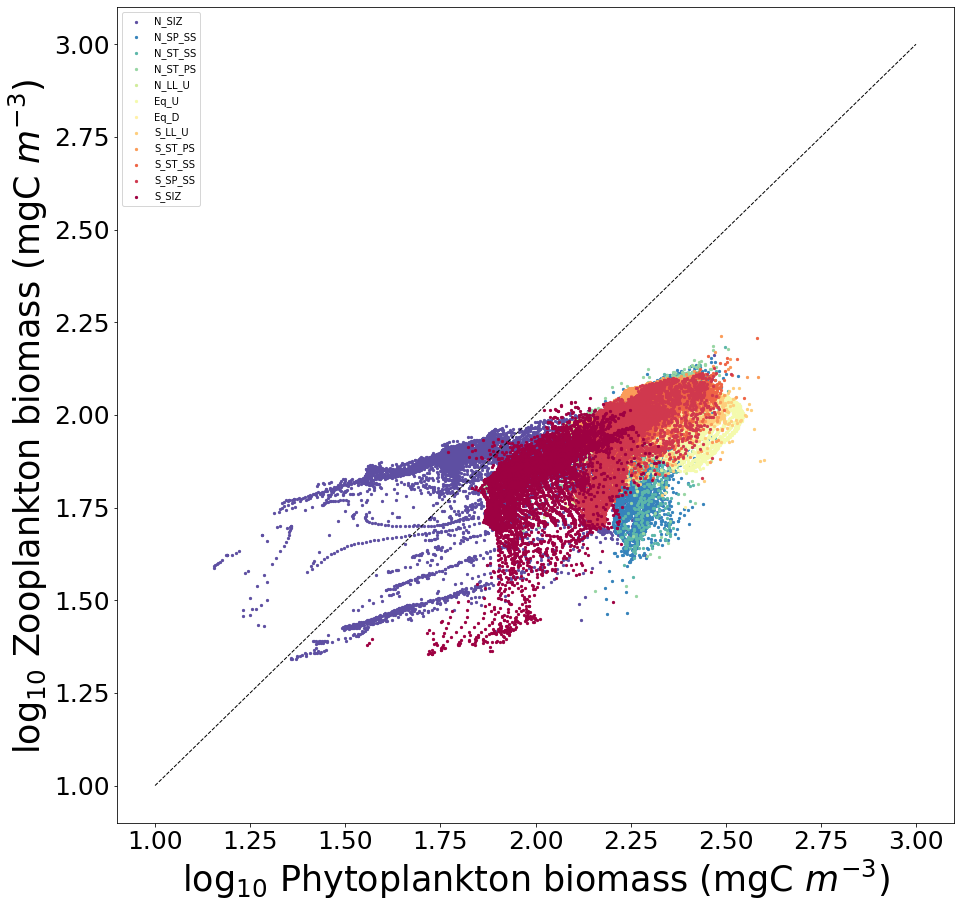

In [58]:
from scipy import stats
#fig, ax = plt.figure(figsize=(10, 10))
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
cmap=matplotlib.cm.get_cmap('Spectral_r', 12)
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_N_SIZ,x=phyto_N_SIZ, s=5, alpha=1,color=cmap(0),label='N_SIZ')
plt.scatter(y=zoo_N_SP_SS,x=phyto_N_SP_SS, s=5, alpha=1,color=cmap(1),label='N_SP_SS')
plt.scatter(y=zoo_N_ST_SS,x=phyto_N_ST_SS, s=5, alpha=1,color=cmap(2),label='N_ST_SS')
plt.scatter(y=zoo_N_ST_PS,x=phyto_N_ST_PS, s=5, alpha=1,color=cmap(3),label='N_ST_PS')
plt.scatter(y=zoo_N_LL_U,x=phyto_N_LL_U, s=5, alpha=1,color=cmap(4),label='N_LL_U')
plt.scatter(y=zoo_Eq_U,x=phyto_Eq_U, s=5, alpha=1,color=cmap(5),label='Eq_U')
plt.scatter(y=zoo_Eq_D,x=phyto_Eq_D, s=5, alpha=1,color=cmap(6),label='Eq_D')
plt.scatter(y=zoo_S_LL_U,x=phyto_S_LL_U, s=5, alpha=1,color=cmap(7),label='S_LL_U')
plt.scatter(y=zoo_S_ST_PS,x=phyto_S_ST_PS, s=5, alpha=1,color=cmap(8),label='S_ST_PS')
plt.scatter(y=zoo_S_ST_SS,x=phyto_S_ST_SS, s=5, alpha=1,color=cmap(9),label='S_ST_SS')
plt.scatter(y=zoo_S_SP_SS,x=phyto_S_SP_SS, s=5, alpha=1,color=cmap(10),label='S_SP_SS')
plt.scatter(y=zoo_S_SIZ,x=phyto_S_SIZ, s=5, alpha=1,color=cmap(11),label='S_SIZ')
#ax.axis([1, 3, 1, 3])

pylab.legend(loc='outside')  
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('log$_{10}$ Phytoplankton biomass (mgC $m^{-3}$)', fontsize=35)
plt.ylabel('log$_{10}$ Zooplankton biomass (mgC $m^{-3}$) ',fontsize = 35)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Z_P_scatter_log_biome'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

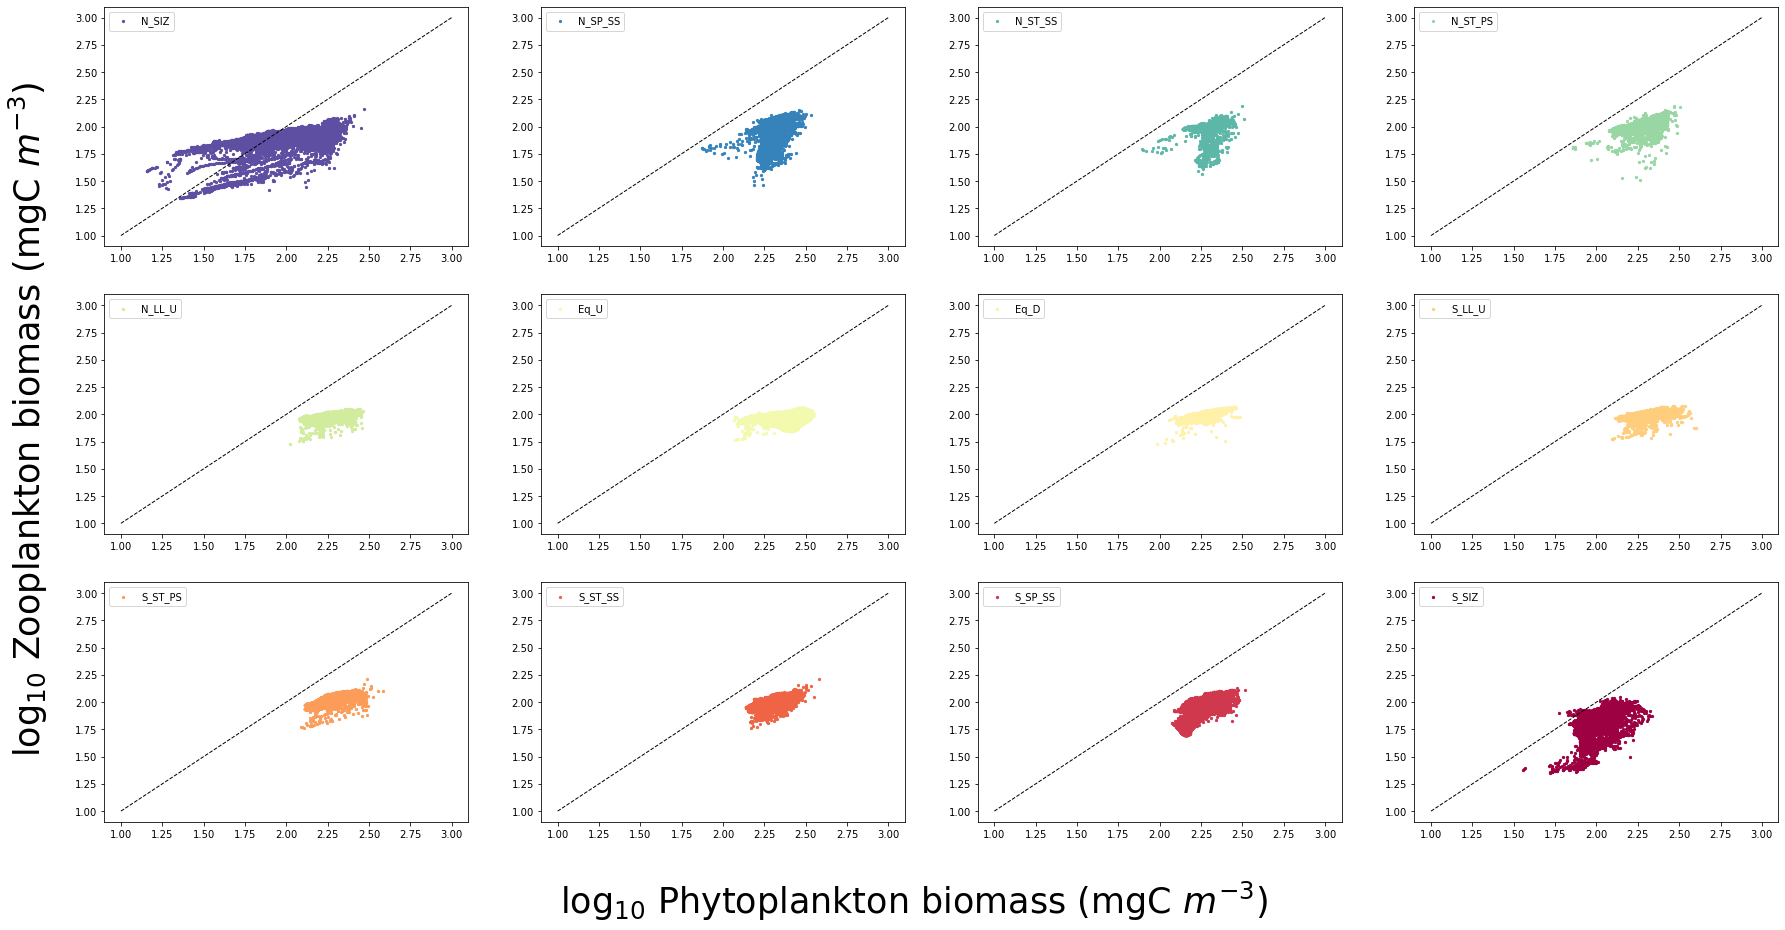

In [59]:
from scipy import stats
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(30, 15))
gs = GridSpec(nrows=3, ncols=4)
cmap=matplotlib.cm.get_cmap('Spectral_r', 12)
ax = fig.add_subplot(gs[0, 0])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_N_SIZ,x=phyto_N_SIZ, s=5, alpha=1,color=cmap(0),label='N_SIZ')
pylab.legend(loc='outside') 
ax = fig.add_subplot(gs[0, 1])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_N_SP_SS,x=phyto_N_SP_SS, s=5, alpha=1,color=cmap(1),label='N_SP_SS')
pylab.legend(loc='outside') 
ax = fig.add_subplot(gs[0, 2])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_N_ST_SS,x=phyto_N_ST_SS, s=5, alpha=1,color=cmap(2),label='N_ST_SS')
pylab.legend(loc='outside') 
ax = fig.add_subplot(gs[0, 3])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_N_ST_PS,x=phyto_N_ST_PS, s=5, alpha=1,color=cmap(3),label='N_ST_PS')
pylab.legend(loc='outside') 
ax = fig.add_subplot(gs[1, 0])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_N_LL_U,x=phyto_N_LL_U, s=5, alpha=1,color=cmap(4),label='N_LL_U')
pylab.legend(loc='outside') 
ax = fig.add_subplot(gs[1, 1])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_Eq_U,x=phyto_Eq_U, s=5, alpha=1,color=cmap(5),label='Eq_U')
pylab.legend(loc='outside') 
ax = fig.add_subplot(gs[1, 2])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_Eq_D,x=phyto_Eq_D, s=5, alpha=1,color=cmap(6),label='Eq_D')
pylab.legend(loc='outside') 
ax = fig.add_subplot(gs[1, 3])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_S_LL_U,x=phyto_S_LL_U, s=5, alpha=1,color=cmap(7),label='S_LL_U')
pylab.legend(loc='outside') 
ax = fig.add_subplot(gs[2, 0])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_S_ST_PS,x=phyto_S_ST_PS, s=5, alpha=1,color=cmap(8),label='S_ST_PS')
pylab.legend(loc='outside') 
ax = fig.add_subplot(gs[2, 1])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_S_ST_SS,x=phyto_S_ST_SS, s=5, alpha=1,color=cmap(9),label='S_ST_SS')
pylab.legend(loc='outside') 
ax = fig.add_subplot(gs[2, 2])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_S_SP_SS,x=phyto_S_SP_SS, s=5, alpha=1,color=cmap(10),label='S_SP_SS')
pylab.legend(loc='outside') 
ax = fig.add_subplot(gs[2, 3])
plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_S_SIZ,x=phyto_S_SIZ, s=5, alpha=1,color=cmap(11),label='S_SIZ')
pylab.legend(loc='outside')  
#plt.yticks(fontsize= 25 );
#plt.xticks(fontsize= 25 );
fig.text(0.5, 0.04, 'log$_{10}$ Phytoplankton biomass (mgC $m^{-3}$)', ha='center',fontsize = 35)
fig.text(0.08, 0.5, 'log$_{10}$ Zooplankton biomass (mgC $m^{-3}$) ', va='center', rotation='vertical',fontsize = 35)
#plt.xlabel('log$_{10}$ Phytoplankton biomass (mgC $m^{-3}$)', fontsize=35)
#plt.ylabel('log$_{10}$ Zooplankton biomass (mgC $m^{-3}$) ',fontsize = 35)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Z_P_scatter_log_biomes_each'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

## Understanding bottom-up and top-down control

### Small phytoplankton and grazers

In [ ]:
phyto_small_names = ['pp','mp1']
phyto_small_vars = [''+v+'C' for v in phyto_small_names] # mmol C /m^3
phytoC_small = xr.concat([ds[v] for v in phyto_small_vars], dim='var').sum(dim='var') # units are mmol
phytoC_small_zint = phytoC_small.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2


zoo_small_names = ['zoo1', 'zoo2']
zooC_small = xr.concat([ds[v+'C'] for v in zoo_small_names], dim='var').sum(dim='var')
zooC_small_zint = zooC_small.sum(dim='z_t_150m') * 10

### Medium phytoplankton and grazers

In [ ]:
phyto_med_names = ['diaz','diat1','mp2']
phyto_med_vars = [''+v+'C' for v in phyto_med_names] # mmol C /m^3
phytoC_med = xr.concat([ds[v] for v in phyto_med_vars], dim='var').sum(dim='var') # units are mmol
phytoC_med_zint = phytoC_med.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

zoo_med_names = ['zoo1', 'zoo2','zoo3', 'zoo4']
zooC_med = xr.concat([ds[v+'C'] for v in zoo_med_names], dim='var').sum(dim='var')
zooC_med_zint = zooC_med.sum(dim='z_t_150m') * 10

### Large phytoplankton and grazers

In [ ]:
phyto_lg_names = ['diat2','mp3','diat3','mp4']
phyto_lg_vars = [''+v+'C' for v in phyto_lg_names] # mmol C /m^3
phytoC_lg = xr.concat([ds[v] for v in phyto_lg_vars], dim='var').sum(dim='var') # units are mmol
phytoC_lg_zint = phytoC_lg.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

zoo_lg_names = ['zoo2','zoo3', 'zoo4', 'zoo5']
zooC_lg = xr.concat([ds[v+'C'] for v in zoo_med_names], dim='var').sum(dim='var')
zooC_lg_zint = zooC_lg.sum(dim='z_t_150m') * 10

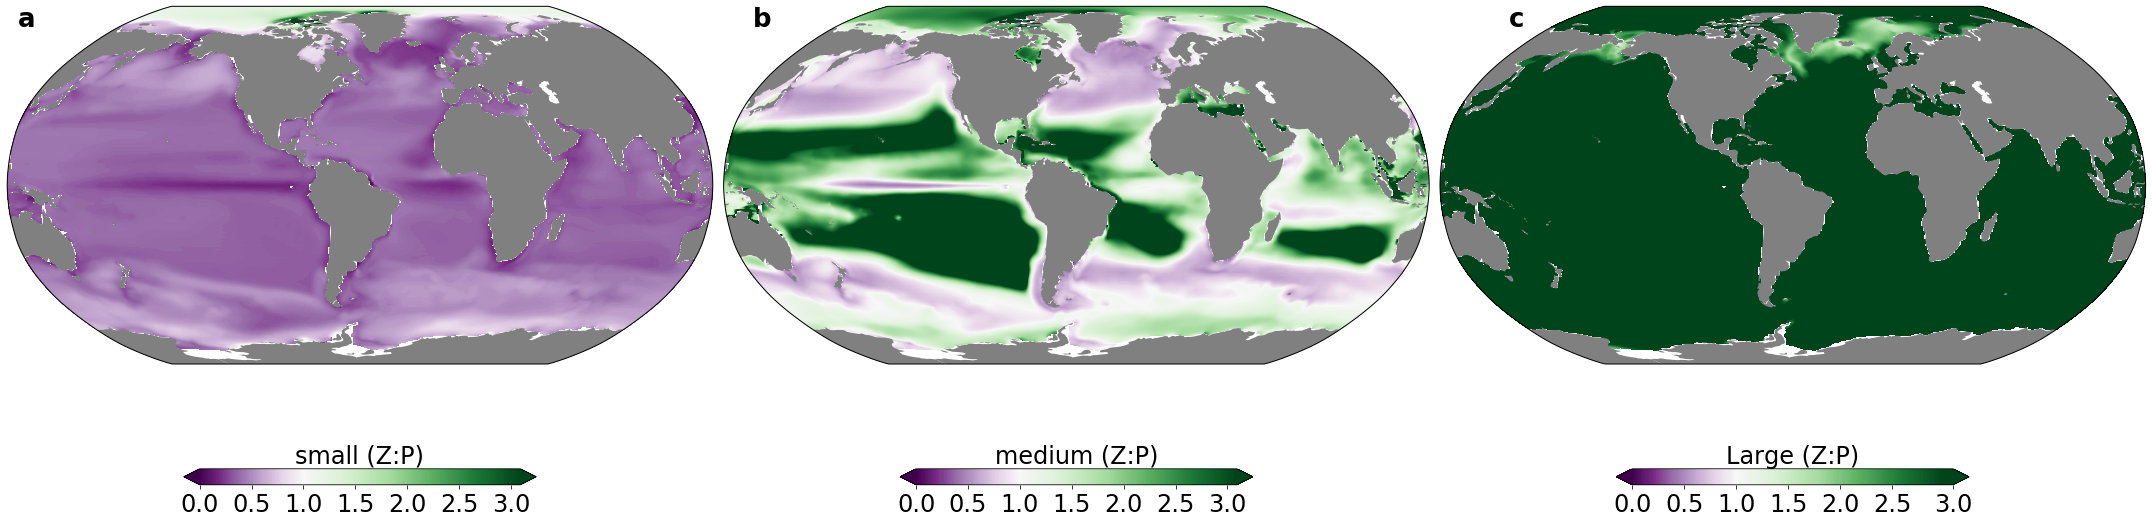

In [63]:
fig = plt.figure(figsize=(30, 10))

lev = np.arange(0, 3.1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
levels = [1]
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooC_small_zint.mean(dim='time')/phytoC_small_zint.mean(dim='time'))
ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='PRGn',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,0.5,1,1.5,2,2.5,3],shrink=0.5, orientation='horizontal')
cb.ax.set_title('small (Z:P)', fontsize = 24)
cb.ax.tick_params(labelsize=24)

lev = np.arange(0, 3.1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
levels = [1]
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooC_med_zint.mean(dim='time')/phytoC_med_zint.mean(dim='time'))
ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='PRGn',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,0.5,1,1.5,2,2.5,3],shrink=0.5, orientation='horizontal')
cb.ax.set_title('medium (Z:P)', fontsize = 24)
cb.ax.tick_params(labelsize=24)
#fig.text(0.15, 0.89, 'a',fontsize=14, fontweight='bold')

lev = np.arange(0, 3.1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
levels = [1]
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooC_lg_zint.mean(dim='time')/phytoC_lg_zint.mean(dim='time'))
ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='PRGn',vmin = 0, vmax=3,levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,0.5,1,1.5,2,2.5,3],shrink=0.5, orientation='horizontal')
cb.ax.set_title('Large (Z:P)', fontsize = 24)
cb.ax.tick_params(labelsize=24)
fig.text(0.01, 0.775, 'a',fontsize=26, fontweight='bold')
fig.text(0.35, 0.775, 'b',fontsize=26, fontweight='bold')
fig.text(0.7, 0.775, 'c',fontsize=26, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/sized_ZPratio'+new_file+'.png',dpi=600, bbox_inches='tight')

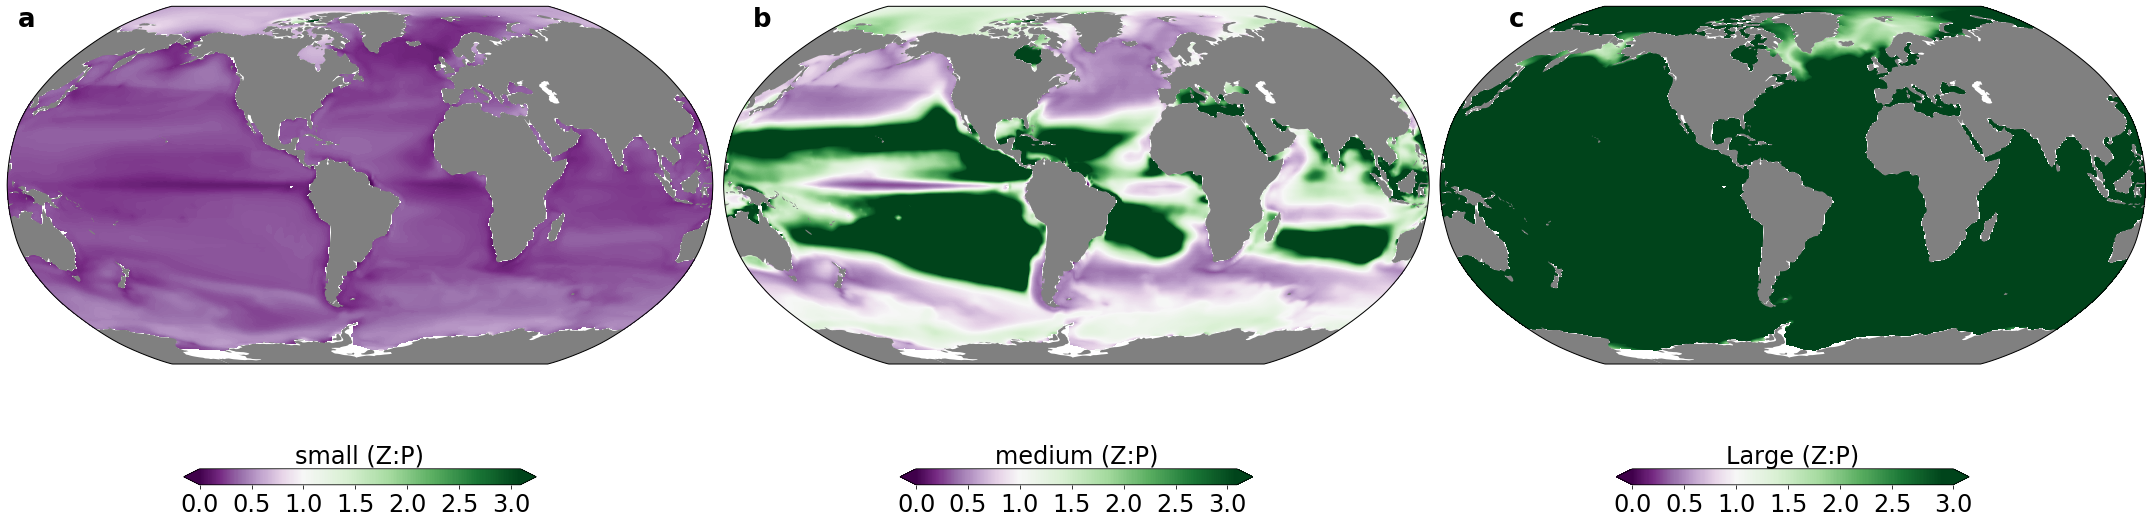

In [64]:
fig = plt.figure(figsize=(30, 10))

lev = np.arange(0, 3.1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
levels = [1]
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooC_small[:,0,:,:].mean(dim='time')/phytoC_small[:,0,:,:].mean(dim='time'))
ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='PRGn',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,0.5,1,1.5,2,2.5,3],shrink=0.5, orientation='horizontal')
cb.ax.set_title('small (Z:P)', fontsize = 24)
cb.ax.tick_params(labelsize=24)

lev = np.arange(0, 3.1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
levels = [1]
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooC_med[:,0,:,:].mean(dim='time')/phytoC_med[:,0,:,:].mean(dim='time'))
ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='PRGn',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,0.5,1,1.5,2,2.5,3],shrink=0.5, orientation='horizontal')
cb.ax.set_title('medium (Z:P)', fontsize = 24)
cb.ax.tick_params(labelsize=24)
#fig.text(0.15, 0.89, 'a',fontsize=14, fontweight='bold')

lev = np.arange(0, 3.1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
levels = [1]
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooC_lg[:,0,:,:].mean(dim='time')/phytoC_lg[:,0,:,:].mean(dim='time'))
ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='PRGn',vmin = 0, vmax=3,levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,0.5,1,1.5,2,2.5,3],shrink=0.5, orientation='horizontal')
cb.ax.set_title('Large (Z:P)', fontsize = 24)
cb.ax.tick_params(labelsize=24)
fig.text(0.01, 0.775, 'a',fontsize=26, fontweight='bold')
fig.text(0.35, 0.775, 'b',fontsize=26, fontweight='bold')
fig.text(0.7, 0.775, 'c',fontsize=26, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/sized_ZPratio_surface'+new_file+'.png',dpi=600, bbox_inches='tight')

## plot the fraction of NPP lost to sinking (export ratio)

In [65]:
e_ratio_s = ds.POC_PROD.isel(z_t=slice(None,10)).sum(dim=['z_t','nlat','nlon']) / \
            ds.photoC_TOT.isel(z_t_150m=slice(None,10)).sum(dim=['z_t_150m','nlat','nlon']) 

Text(0.5, 1.0, 'e-ratio (over top 100 m)')

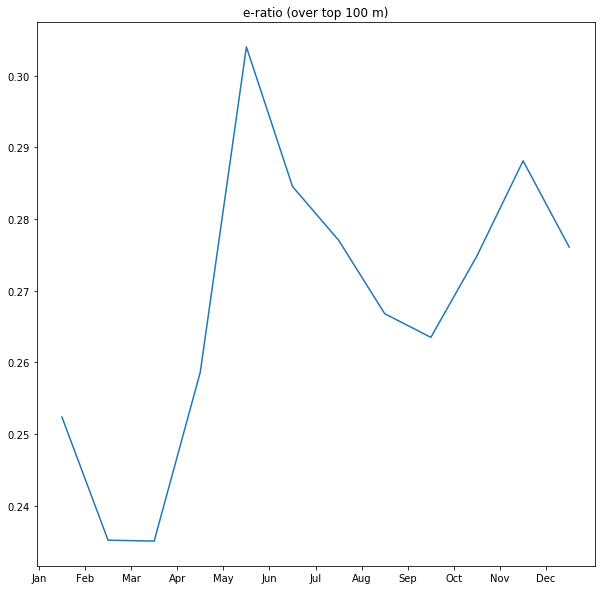

In [66]:
fig = plt.figure(figsize=(10, 10))
plt.plot(month,e_ratio_s.values)
plt.xticks(np.arange(0.5,12.5,1), ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title("e-ratio (over top 100 m)")

In [67]:
e_ratio =  ds.POC_PROD.isel(z_t=slice(None,10)).sum(dim=['z_t'])/ ds.photoC_TOT.isel(z_t_150m=slice(None,10)).sum(dim=['z_t_150m'])
prod = ds.POC_PROD.isel(z_t=slice(None,10)).sum(dim=['z_t'])
npp = ds.photoC_TOT.isel(z_t_150m=slice(None,10)).sum(dim=['z_t_150m'])

## Production, NPP and E-ratio
(NPP) = the Gross Primary Production (GPP) minus Respiration (R)
e-ratio should be the export production over net primary production

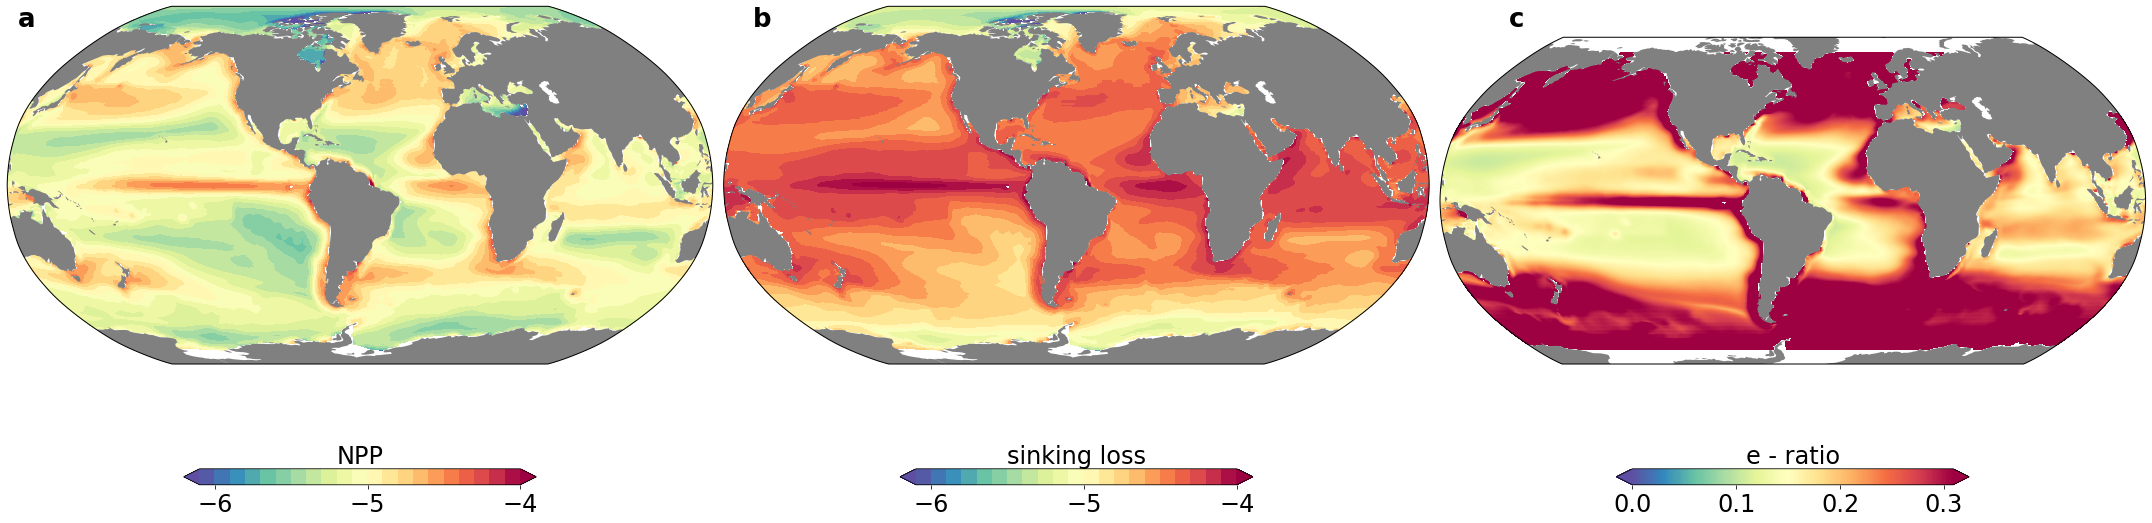

In [78]:
fig = plt.figure(figsize=(30, 10))

lev = np.arange(-6.1, -3.9, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-5)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.log10(prod.mean(dim=['time'])))
ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-6,-5,-4],shrink=0.5, orientation='horizontal')
cb.ax.set_title('NPP', fontsize = 24)
cb.ax.tick_params(labelsize=24)

lev = np.arange(-6.1, -3.9, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-5)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.log10(npp.mean(dim=['time'])))
ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-6,-5,-4],shrink=0.5, orientation='horizontal')
cb.ax.set_title('sinking loss', fontsize = 24)
cb.ax.tick_params(labelsize=24)

lev = np.arange(0, 0.31, 0.001)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=.15)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, e_ratio.mean(dim='time'))
ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,0.1,0.2,0.3],shrink=0.5, orientation='horizontal')
cb.ax.set_title('e - ratio', fontsize = 24)
cb.ax.tick_params(labelsize=24)
fig.text(0.01, 0.775, 'a',fontsize=26, fontweight='bold')
fig.text(0.35, 0.775, 'b',fontsize=26, fontweight='bold')
fig.text(0.7, 0.775, 'c',fontsize=26, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/e-ratio'+new_file+'.png',dpi=600, bbox_inches='tight')